In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

#Dataset:
Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr


In [2]:
dataset_cols = ["bike_count" , "hour" , "temp" , "humidity" , "wind" , "visibility" , "dew_pt_temp" , "radiation" , "rain" , "snow" , "functional"]

df = pd.read_csv("/content/drive/MyDrive/Machine Learning - Colab/Bikes/SeoulBikeData_formatted.csv").drop(["Date", "Holiday" , "Seasons"], axis=1)

In [3]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df  = df[df["hour"] == 12]
df = df.drop(["hour"], axis = 1)

In [4]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


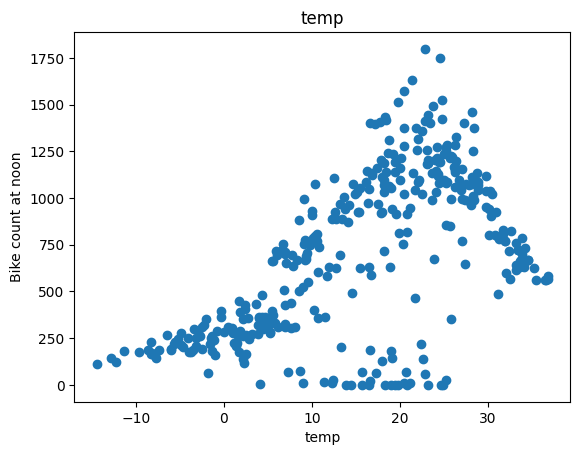

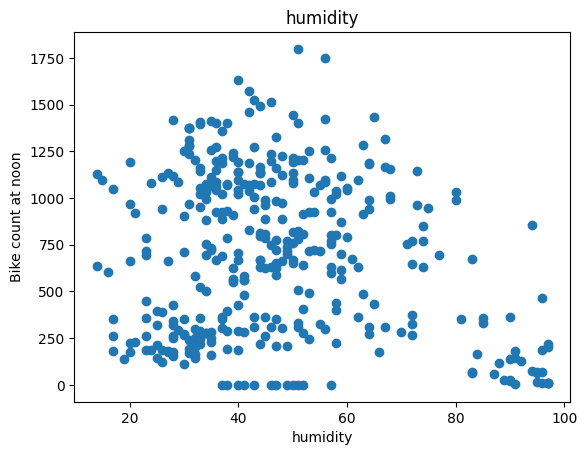

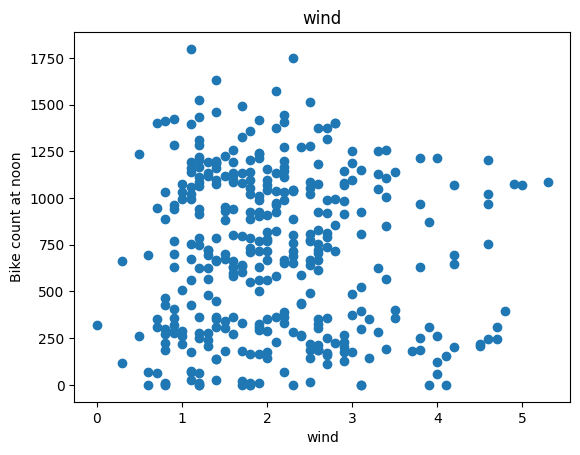

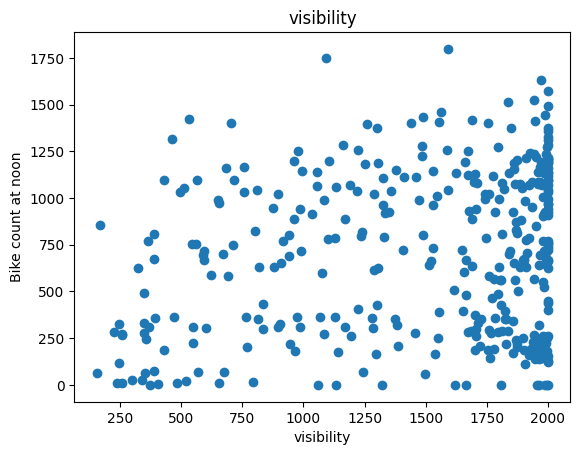

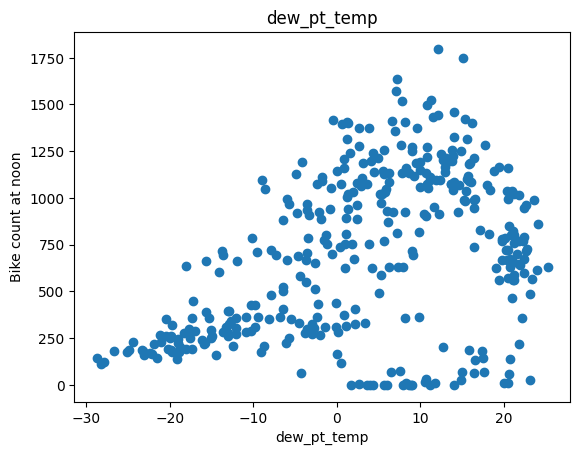

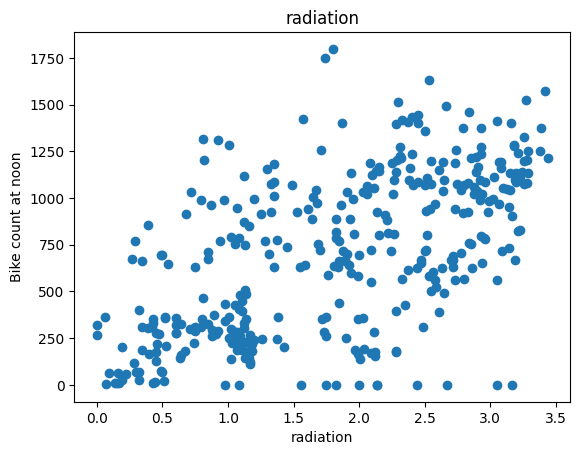

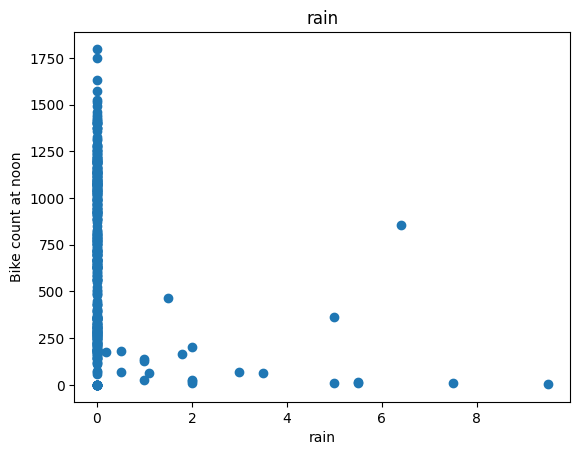

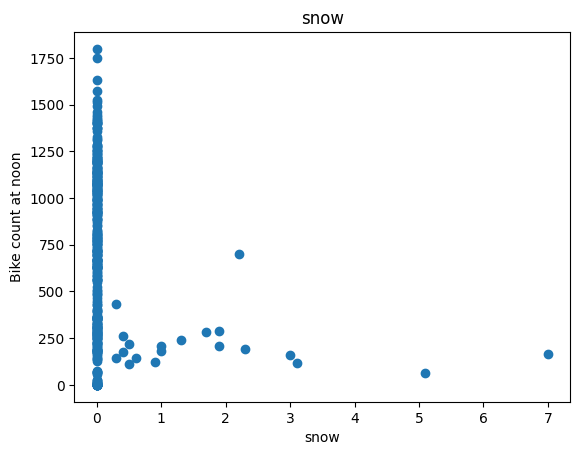

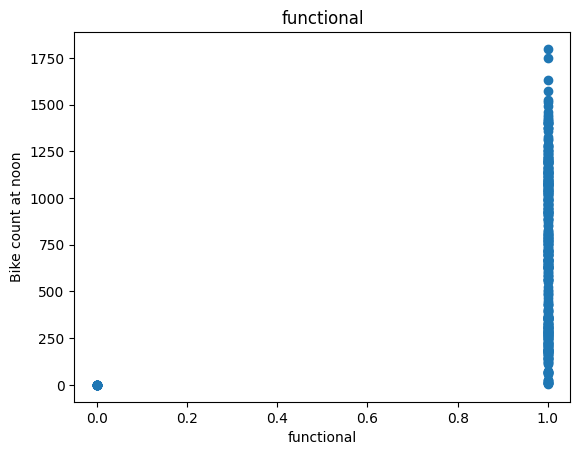

In [5]:
for lable in df.columns[1: ]:
  plt.scatter(df[lable], df["bike_count"])
  plt.title(lable)
  plt.ylabel("Bike count at noon")
  plt.xlabel(lable)
  plt.show()

In [6]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

#Train-Valid-Test dataset 

In [7]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8 * len(df))])

In [8]:
def get_xy(dataframe, y_label, x_labels = None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X, y))

  return data, X, y

In [9]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [10]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [11]:
temp_reg.score(X_test_temp, y_test_temp)

0.21330673065718497

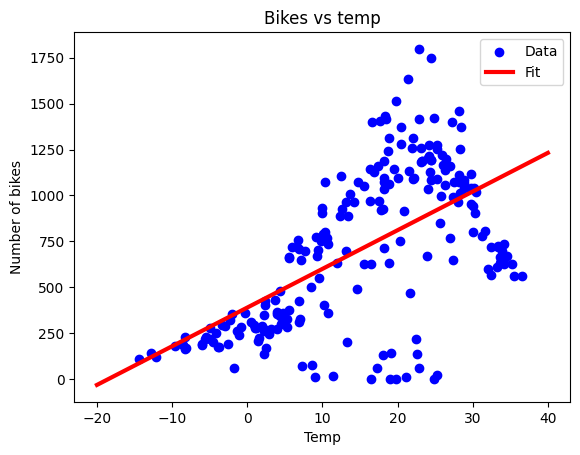

In [12]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [13]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8 * len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [14]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [15]:
all_reg.score(X_test_all, y_test_all)

0.4307339113974493

#Regression with Neural Net 

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [17]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [18]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [19]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [20]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs = 1000,
    validation_data=(X_val_temp, y_val_temp)
)

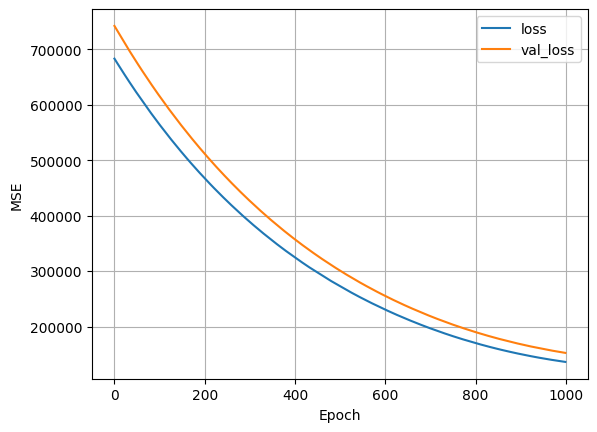

In [21]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


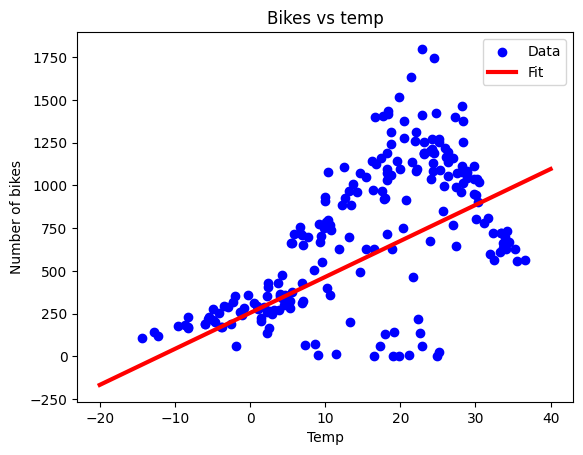

In [22]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#Nural Net

In [23]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [24]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_val_temp, y_val_temp),
    epochs=100, verbose=0
)

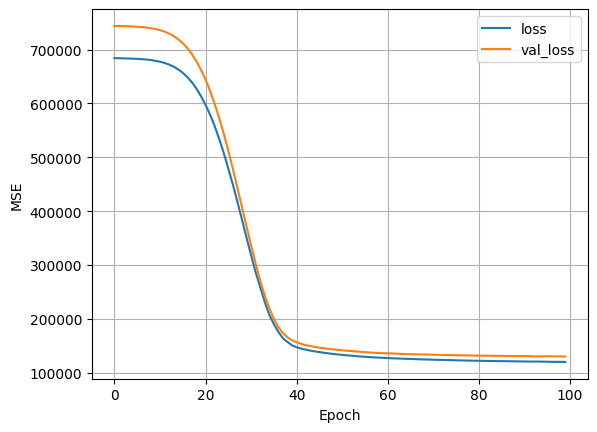

In [25]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


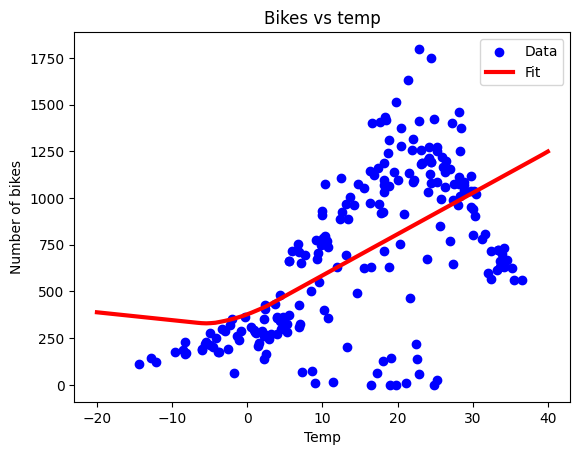

In [26]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [36]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [37]:
nn_model = tf.keras.Sequential([

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [38]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_val_all, y_val_all),
    epochs=100, verbose=0
)

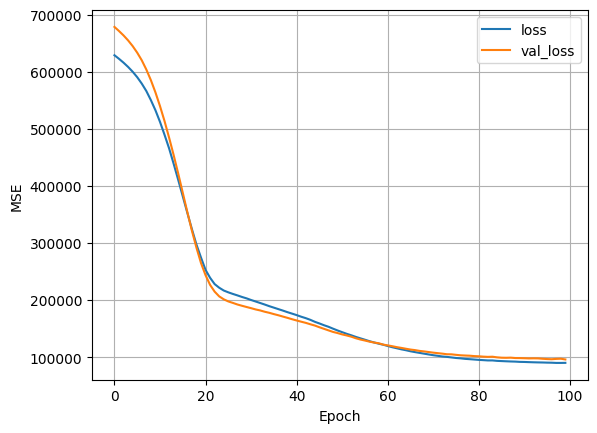

In [39]:
plot_loss(history)

#calculate the mean square error


In [40]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 4ms/step


In [41]:
def mse(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [42]:
mse(y_pred_lr, y_test_all)

101460.94937659767

In [43]:
mse(y_pred_nn, y_test_all)

97335.21448863101

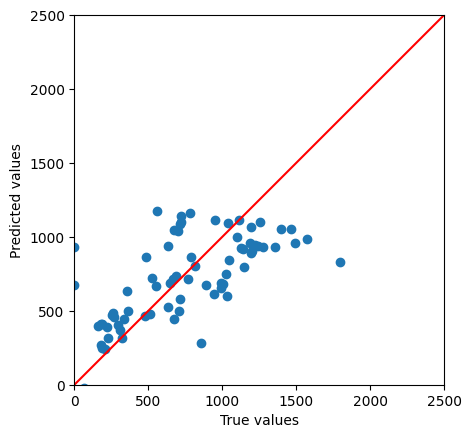

In [55]:
ax = plt.axes( aspect ='equal')
plt.scatter( y_test_all, y_pred_lr, label='Lin reg preds')
plt.xlabel('True values')
plt.ylabel('Predicted values')
lims = [0, 2500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, c='red')